# Physical Properties of Rivers: Calculating Recurrence Interval and Exceedance Probability

This lesson was adapted from educational material written by [Dr. Kateri Salk](https://www.hydroshare.org/user/4912/) for her Fall 2019 Hydrologic Data Analysis course at Duke University. This is the first part of a two-part exercise focusing on the physical properties of rivers. 

## Introduction

Rivers are bodies of freshwater flowing from higher elevations to lower elevations due to the force of gravity. One of the most important physical characteristics of a stream or river is **discharge**, the volume of water moving through the river or stream over a given amount of time. This exercise will introduce the concepts of **Recurrence Intervals** and **Exceedance Probability** for the prediction of streamflow discharge. 

## Learning Objectives 

After successfully completing this exercise, you will be able to:

1. Execute queries to pull a variety of National Water Information System (NWIS) and Water Quality Portal (WQP) data into R.
2. Calculate recurrence interval and exceedance probability from daily discharge data. 

## Requirements to Complete Lesson 

### Packages 
This lesson requires the installation of the following R packages to run the provided script:
- `tidyverse`- Version 1.3.0. A collection of R packages designed for data science. 
- `lubridate`- Version 1.7.9. Functions for working with dates/times. 
- `ggplot2`- Version 3.3.3. Creates elegant data visualisations using the Grammar of Graphics.
- `scales`- Version 1.1.1. Graphical scales provide methods for automatically determining breaks and labels for axes and legends.
- `dataRetrieval`- Version 2.7.6. Retrieval Functions for USGS and EPA Hydrologic and Water Quality Data.

### Data and Code 

This lesson will import daily discharge data for the Eno River near Durham, North Carolina for the entire period of record using the `dataRetrieval` package. The package was created to make querying and downloading hydrologic data from the USGS National Water Information System (NWIS) and the multi-agency database, Water Quality Portal (WQP) easier. NWIS contains streamflow, peak flow, rating curves, groundwater, and water quality data data collected by or for the USGS. WQP only contains water quality data.

It should be noted that the databases are not static as data is constantly being added.  For more in-depth information on the `dataRetrieval` package, please visit https://cran.r-project.org/web/packages/dataRetrieval/vignettes/dataRetrieval.html. 

The code provided in this resource was developed using R version 3.6.1. 

### Set Working Directory 

In R, the working directory is the directory where R starts when looking for any file to open (as directed by a file path) and where it saves any output. This lesson assumes that you have set your working directory to the folder location of the downloaded and unzipped data subsets.

### Load Packages and set ggplot theme

In [3]:
options(warn=-1)

library(tidyverse)
library(lubridate)
library(ggplot2)
library(scales)
library(dataRetrieval)

theme_set(theme_gray()) 

## Recurrence Intervals and Exceedance Probability 

A **recurrence interval** is the past recurrence of an event, in this case a peak annual discharge measurement of a given magnitude. We use this to predict what we'd expect a peak discharge to be annually.  The value of a recurrence interval corresponds to the average number of years between discharge of a given magnitude. Typically the minimum amount of years required to construct a recurrence interval is 10, but 30 is more robust. The more years we have of data, the more statistical power we have and the more robust our model. A recurrence interval, T, is calculated as: 

**$T = (n+1)/m$**

where n is the number of years and m is the ranking of an event within the observed period. We add one to n because we are computing the recurrence interval for a discharge event of a given magnitude *or greater*. 

Similarly, we can calculate an **exceedance probability**, or the probability of encountering a discharge event of a given magnitude or greater in any given year: 

**$P = 1/T$**

This is where the terms "100-year flood" and similar are derived. Remember this is a probability based on past occurrence, not an accurate forecast of how often we will see that event happening. When current patterns of discharge differ from past patterns, we observe **nonstationary** behavior. Nonstationarity results in events that occur more or less frequency than predicted based on the exceedance probability.



## Import Daily Discharge Data from the Eno River 

## `readNWISdv`
Use the `readNWISdv` function to import daily discharge data from NWIS web service. You can access the complete list of NWIS parameter codes here: https://nwis.waterdata.usgs.gov/nwis/pmcodes. 

The following are key parameter codes that serve as arguments for the `readNWISdv` function:


**siteNumbers**: character USGS site number. This is usually an 8 digit number. Multiple sites can be requested with a character vector.

**parameterCd**: character of USGS parameter code(s). This is usually an 5 digit number.

**startDate**: character starting date for data retrieval in the form YYYY-MM-DD.
Default is "" which indicates retrieval for the earliest possible record. Date arguments are always specified in local time.

**endDate**: character ending date for data retrieval in the form YYYY-MM-DD.
Default is "" which indicates retrieval for the latest possible record. Date arguments are always specified in local time.

**statCd**: character USGS statistic code. This is usually 5 digits. Daily mean (00003) is the default.

In [4]:

EnoDischarge <- readNWISdv(siteNumbers = "02085070", #site number for Eno River
                     parameterCd = "00060", # parameter code for discharge (ft3/s)
                     startDate = "",
                     endDate = "")

names(EnoDischarge)[4:5] <- c("Discharge", "Approval.Code") #rename column headers

In [5]:
head(EnoDischarge) #only view the first six observations of the dataframe

,agency_cd,site_no,Date,Discharge,Approval.Code
,<chr>,<chr>,<date>,<dbl>,<chr>
1,USGS,02085070,1963-09-01,6.3,A
2,USGS,02085070,1963-09-02,5.7,A
3,USGS,02085070,1963-09-03,5.1,A
4,USGS,02085070,1963-09-04,4.8,A
5,USGS,02085070,1963-09-05,5.4,A
6,USGS,02085070,1963-09-06,5.4,A


### Create a 'Year' column and view the first six observations

In [6]:
EnoDischarge <- 
  EnoDischarge %>%
  mutate(Year = year(Date))

In [7]:
head(EnoDischarge)

,agency_cd,site_no,Date,Discharge,Approval.Code,Year
,<chr>,<chr>,<date>,<dbl>,<chr>,<dbl>
1,USGS,02085070,1963-09-01,6.3,A,1963
2,USGS,02085070,1963-09-02,5.7,A,1963
3,USGS,02085070,1963-09-03,5.1,A,1963
4,USGS,02085070,1963-09-04,4.8,A,1963
5,USGS,02085070,1963-09-05,5.4,A,1963
6,USGS,02085070,1963-09-06,5.4,A,1963


## Construct a plot comparing Year and Discharge at Eno River

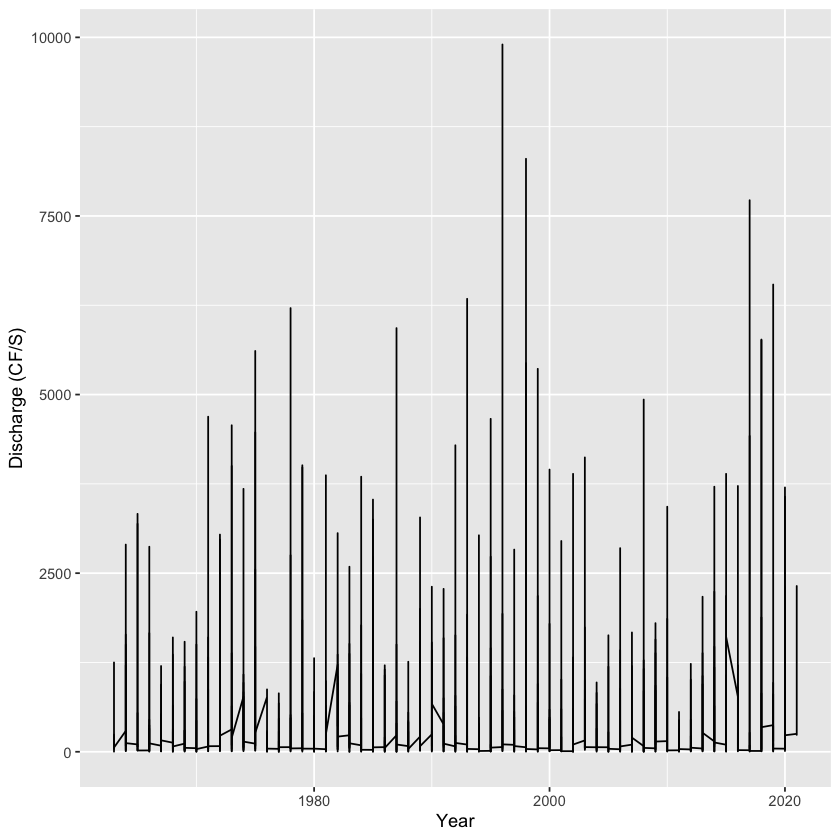

In [8]:
EnoPlot <- 
  ggplot(EnoDischarge, aes(x = Year, y = Discharge)) +
         geom_line() +
         xlab("Year")+
         ylab("Discharge (CF/S)")
print(EnoPlot)

## Compute Recurrence Intervals and Exceedance Probabilities based on the first 30 years of data at Eno River

1.) Use the `filter` function to extract the years before 1993 to create a 30 year period of record

2.) Use the `group_by` function to group by year (so each year has its own separate set of data)

3.) Use the `summarise` function to create a new column summarizing the maximum discharge per year

4.) Use the `mutate` function to: 

    -Add a Rank column using the `rank` function 
    
    -Add a Recurrence Interval column by using the 𝑇=(𝑛+1)/𝑚 equation 
    
    -Add an Exceedance Probability column by using the 𝑇=(𝑛+1)/𝑚 equation
    


In [9]:
EnoRecurrence <- 
  EnoDischarge %>%
  filter(Year < 1993) %>%
  group_by(Year) %>%  
  summarise(PeakDischarge = max(Discharge)) %>%   #computes max discharge of each year through 1992
  mutate(Rank = rank(PeakDischarge),    #Add Rank column. The Rank function ranks peak discharge measurements from 1-30 
         RecurrenceInterval = (length(Year) + 1)/Rank, #Take equation from above and compute it; number of years in data frame +1/Rank.
         ExceedanceProbability = 1/RecurrenceInterval)  #compute exceedance probability


`summarise()` ungrouping output (override with `.groups` argument)



### View newly created Dataframe and `order` the rank column 

In [10]:
EnoRecurrence[
  with(EnoRecurrence, order(Rank)),
]


Year,PeakDischarge,Rank,RecurrenceInterval,ExceedanceProbability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1977,818,1,31.000000,0.03225806
1976,873,2,15.500000,0.06451613
1967,1200,3,10.333333,0.09677419
1986,1210,4,7.750000,0.12903226
1963,1250,5,6.200000,0.16129032
1988,1260,6,5.166667,0.19354839
1980,1310,7,4.428571,0.22580645
1969,1540,8,3.875000,0.25806452
1968,1600,9,3.444444,0.29032258


In any given year, for rank 30, we have a 97% probability that we'll see that amount of discharge or higher in a given year. For rank 1, we have a 3% probability of seeing that amount of discharge or higher in a given year. 

## Create a barplot displaying the Peak Discharge over time

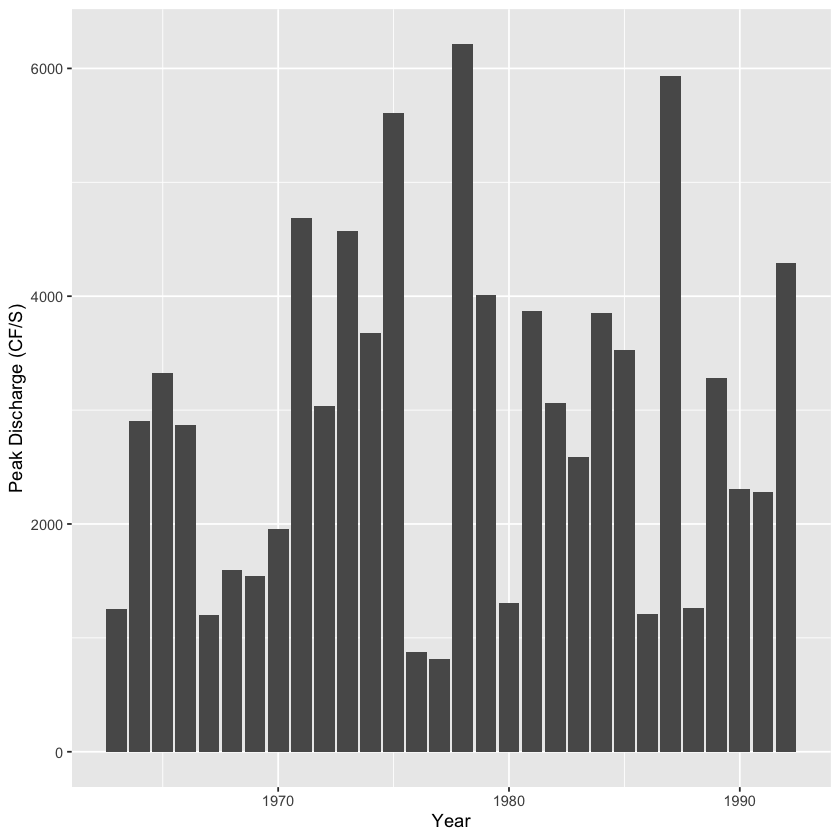

In [11]:
EnoPeakPlot <- 
  ggplot(EnoRecurrence, aes(x = Year, y = PeakDischarge)) +
         geom_bar(stat="identity") +  #If you want the heights of the bars to represent values in the data, use stat="identity" and map a value to the y aesthetic
         xlab("Year") +
         ylab("Peak Discharge (CF/S)")

print(EnoPeakPlot)

## Construct a scatterplot comparing the relationship between Recurrence Interval and Peak Discharge

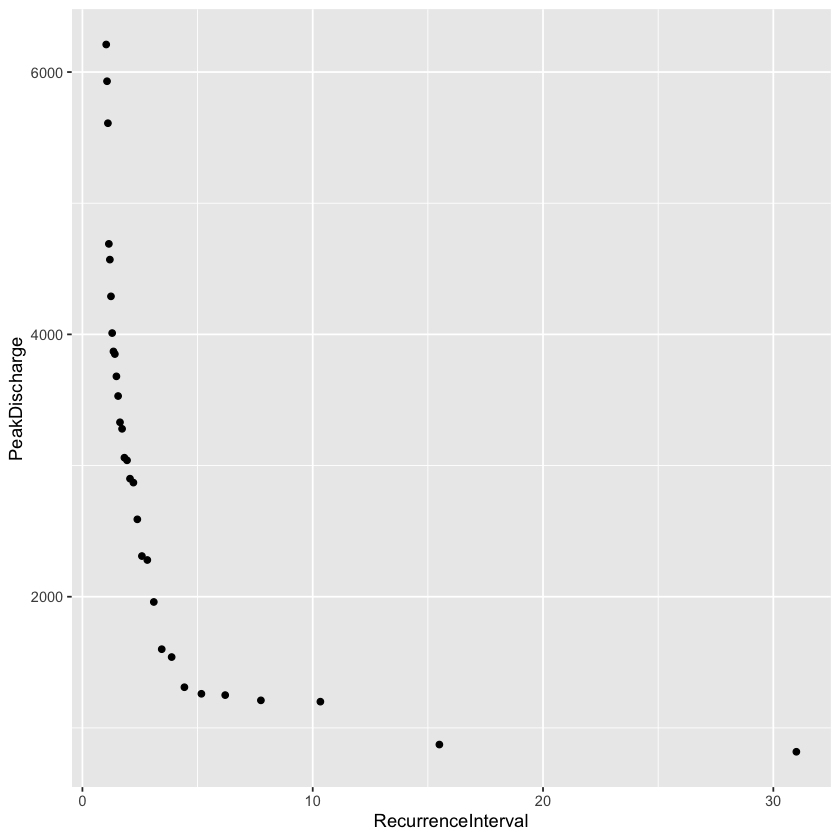

In [12]:
EnoRecurrencePlot <- 
  ggplot(EnoRecurrence, aes(x = RecurrenceInterval, y = PeakDischarge)) +
  geom_point() 
  
print(EnoRecurrencePlot)

## Model the linear relationship between Peak Annual Discharge and Recurrence Interval and display summary statistics of the model

## `lm`
Use the `lm` function to fit a linear regression. A linear regression is a statistical model that analyzes the relationship between a response variable (often called y) and one or more variables and their interactions (often called x or explanatory variables). The lm command takes the variables in the format:

**lm([response variable] ~ [explanatory variable], data =[dataframe])**

## `summary`

The `summary`function produces result summaries of the results of various model fitting functions. For more information on summary statistics, visit http://r-statistics.co/Linear-Regression.html. 

In [13]:
Eno.RImodel <- lm(data = EnoRecurrence, PeakDischarge ~RecurrenceInterval)
summary(Eno.RImodel)


Call:
lm(formula = PeakDischarge ~ RecurrenceInterval, data = EnoRecurrence)

Residuals:
    Min      1Q  Median      3Q     Max 
-1609.6  -881.3  -246.4   593.6  2788.4 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          3574.4      281.0  12.722 3.71e-13 ***
RecurrenceInterval   -147.9       39.1  -3.782 0.000752 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1260 on 28 degrees of freedom
Multiple R-squared:  0.3381,	Adjusted R-squared:  0.3145 
F-statistic:  14.3 on 1 and 28 DF,  p-value: 0.0007518


## Using the summary results from the linear model, calculate the resultant discharge for a 100-year flood

In [14]:
Eno.RImodel$coefficients[1] + Eno.RImodel$coefficients[2]*log(100)

(Intercept) 
   2893.502

[1] is the y-intercept of the model, and [2] is the coefficient of the predictor variable (Recurrence Interval). This takes the coefficient of the y-intercept plus the coefficient of the recurrence interval times the log of the 100 year flood value. Therefore, the resultant discharge for a 100-year flood at the Eno River is 2893.5 cfs. 